# Webcam Emotion Classification with ONNX (FER+ / Emotion FerPlus)

This Colab notebook captures a frame from your **webcam** (in the browser) and runs the **Emotion FerPlus** ONNX model to classify facial expression into 8 emotion classes.

Model details (from ONNX Model Zoo):
- Input shape: `(N x 1 x 64 x 64)`
- Output: `(1 x 8)` scores for: neutral, happiness, surprise, sadness, anger, disgust, fear, contempt

Notes:
- This is **facial-expression classification**, not medical diagnosis.
- Use only with explicit consent.


## 1) Install dependencies

In [2]:
!pip -q install onnxruntime opencv-python matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.9 MB/s eta 0:00:00


## 2) Download the FER+ ONNX model

We download the model from the ONNX Model Zoo repository.

In [3]:
!wget -q -O emotion-ferplus-8.onnx https://huggingface.co/onnxmodelzoo/emotion-ferplus-8/resolve/main/emotion-ferplus-8.onnx


In [4]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 94.8 MB/s eta 0:00:00


In [5]:
import onnx
m = onnx.load("emotion-ferplus-8.onnx")
print(len(m.graph.node))


52


## 3) Capture a frame from the webcam
Run this cell, allow camera access, then click **Capture**.

In [13]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='webcam.jpg', quality=0.9):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        capture.style.fontSize = '18px';
        capture.style.padding = '8px 16px';
        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.border = '1px solid #ccc';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        div.appendChild(capture);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getVideoTracks()[0].stop();
        div.remove();

        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

img_path = take_photo('webcam.jpg')
print('Saved:', img_path)


<IPython.core.display.Javascript object>

Saved: webcam.jpg


## 4) Detect face, preprocess to (1x1x64x64), and run ONNX Runtime

Preprocessing follows the model card: resize to 64x64 and reshape to `(1,1,64,64)`.
We additionally detect and crop the face region first (Haar cascade) to improve accuracy.

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort

EMOTIONS = ['neutral','happiness','surprise','sadness','anger','disgust','fear','contempt']

def softmax(x):
    x = x - np.max(x)
    ex = np.exp(x)
    return ex / np.sum(ex)

# Load model once
sess = ort.InferenceSession('emotion-ferplus-8.onnx', providers=['CPUExecutionProvider'])
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

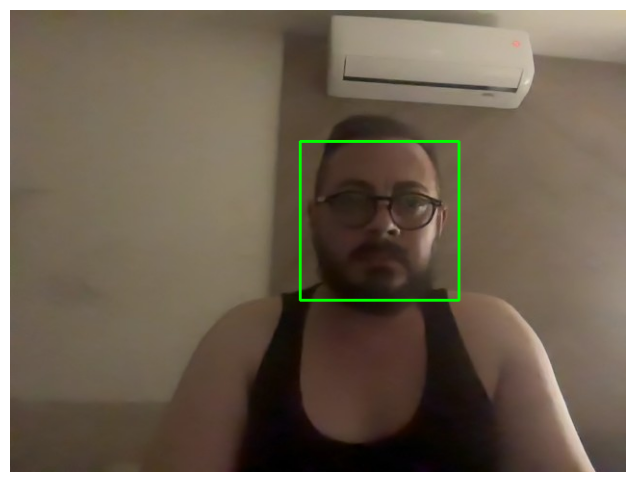

Top emotion: neutral prob= 0.9185492396354675
neutral     0.9185
happiness   0.0078
surprise    0.0268
sadness     0.0389
anger       0.0028
disgust     0.0004
fear        0.0017
contempt    0.0030


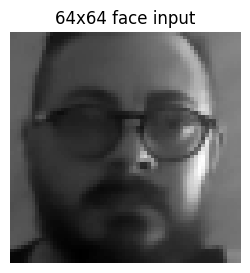

In [15]:


# Load image
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise RuntimeError('Failed to read webcam.jpg')
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Face detector (Haar cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))

if len(faces) == 0:
    print('No face detected. Try: better lighting, face centered, closer to camera.')
    # Fallback: use full image
    x, y, w, h = 0, 0, gray.shape[1], gray.shape[0]
else:
    # choose the largest face
    x, y, w, h = max(faces, key=lambda b: b[2]*b[3])

# Visualize detected face box
vis = cv2.cvtColor(img_bgr.copy(), cv2.COLOR_BGR2RGB)
cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.figure(figsize=(8,6))
plt.imshow(vis)
plt.axis('off')
plt.show()

# Crop face
face_gray = gray[y:y+h, x:x+w]

# Resize to 64x64
face_64 = cv2.resize(face_gray, (64, 64), interpolation=cv2.INTER_AREA)

# IMPORTANT: model card shows raw pixel array reshaped to (1,1,64,64)
# Keep as float32 for ONNX Runtime; values remain in 0..255 range.
inp = face_64.astype(np.float32).reshape(1, 1, 64, 64)


# Inference
scores = sess.run([output_name], {input_name: inp})[0]  # shape (1,8) or similar
scores = np.squeeze(scores)
probs = softmax(scores)

top = int(np.argmax(probs))
print('Top emotion:', EMOTIONS[top], 'prob=', float(probs[top]))

# Show probability table
for i, e in enumerate(EMOTIONS):
    print(f"{e:10s}  {probs[i]:.4f}")

# Show face crop
plt.figure(figsize=(3,3))
plt.imshow(face_64, cmap='gray')
plt.title('64x64 face input')
plt.axis('off')
plt.show()


## 5) Capture 10 frames automatically from webcam

In [16]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os

def capture_n_frames(n=10, prefix="frame"):
    js = Javascript(f'''
    async function captureFrames(n) {{
        const div = document.createElement('div');
        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.border = '1px solid #ccc';

        const stream = await navigator.mediaDevices.getUserMedia({{ video: true }});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        const frames = [];
        const canvas = document.createElement('canvas');

        for (let i = 0; i < n; i++) {{
            await new Promise(r => setTimeout(r, 300)); // ~3 FPS
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            frames.push(canvas.toDataURL('image/jpeg', 0.9));
        }}

        stream.getVideoTracks()[0].stop();
        div.remove();
        return frames;
    }}
    ''')
    display(js)

    data = eval_js(f"captureFrames({n})")

    paths = []
    for i, frame in enumerate(data):
        binary = b64decode(frame.split(',')[1])
        path = f"{prefix}_{i:02d}.jpg"
        with open(path, "wb") as f:
            f.write(binary)
        paths.append(path)

    return paths


frame_paths = capture_n_frames(10)
frame_paths


<IPython.core.display.Javascript object>

['frame_00.jpg',
 'frame_01.jpg',
 'frame_02.jpg',
 'frame_03.jpg',
 'frame_04.jpg',
 'frame_05.jpg',
 'frame_06.jpg',
 'frame_07.jpg',
 'frame_08.jpg',
 'frame_09.jpg']

6) Run inference on 10 frames + smoothing (no duplication)

In [17]:




# Face detector once
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def infer_one(path):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise RuntimeError(f"Failed to read {path}")
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(60, 60))
    if len(faces) == 0:
        x, y, w, h = 0, 0, gray.shape[1], gray.shape[0]
    else:
        x, y, w, h = max(faces, key=lambda b: b[2]*b[3])

    face_gray = gray[y:y+h, x:x+w]
    face_64 = cv2.resize(face_gray, (64, 64), interpolation=cv2.INTER_AREA)
    inp = face_64.astype(np.float32).reshape(1, 1, 64, 64)

    scores = sess.run([output_name], {input_name: inp})[0]
    probs = softmax(np.squeeze(scores))
    return probs

# Run on 10 frames
P = np.stack([infer_one(p) for p in frame_paths[:10]], axis=0)  # (10,8)
mean_probs = P.mean(axis=0)

print("Per-frame top:")
for i, probs in enumerate(P):
    top = int(np.argmax(probs))
    print(f"{i:02d} {frame_paths[i]} -> {EMOTIONS[top]} ({float(probs[top]):.3f})")

final_top = int(np.argmax(mean_probs))
print("\nFINAL (smoothed mean):", EMOTIONS[final_top], "(", float(mean_probs[final_top]), ")")

print("\nSmoothed probs:")
for e, v in zip(EMOTIONS, mean_probs):
    print(f"{e:10s} {float(v):.4f}")


Per-frame top:
00 frame_00.jpg -> neutral (0.660)
01 frame_01.jpg -> neutral (0.777)
02 frame_02.jpg -> neutral (0.894)
03 frame_03.jpg -> neutral (0.916)
04 frame_04.jpg -> sadness (0.511)
05 frame_05.jpg -> sadness (0.508)
06 frame_06.jpg -> happiness (0.719)
07 frame_07.jpg -> happiness (0.686)
08 frame_08.jpg -> neutral (0.832)
09 frame_09.jpg -> neutral (0.800)

FINAL (smoothed mean): neutral ( 0.6216655373573303 )

Smoothed probs:
neutral    0.6217
happiness  0.1791
surprise   0.0154
sadness    0.1717
anger      0.0054
disgust    0.0007
fear       0.0036
contempt   0.0024
